<a href="https://colab.research.google.com/github/CatCodeLab/HealthCatalyst/blob/master/NAT_encoder_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Encoder–Decoder Network for Neural Machine Translation


In [2]:
from pathlib import Path
import torch
from torchvision.datasets.utils import download_and_extract_archive

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data import Dataset, DataLoader

import numpy as np

In [3]:
# !pip install -Uqq ipdb
# import ipdb

# %pdb on

In [3]:
# define constants
MAX_LENGTH = 20
max_words = 50

BATCH_SIZE = 128

In [4]:
# check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
# download data
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

filename = 'spa-eng'
to_path = './'
download_and_extract_archive(url, to_path)
text = Path("./spa-eng/spa.txt").read_text()

100%|██████████| 2638744/2638744 [00:00<00:00, 232563448.50it/s]

Extracting ./spa-eng.zip to ./


In [6]:
# prepare the data
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

In [7]:
# example data
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [8]:
# !pip install --upgrade spacy
!python -m spacy download en
!python -m spacy download es


2024-01-16 20:17:48.299527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 20:17:48.299579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 20:17:48.300972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 20:17:49.356106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.1 MB/s eta 0:00:00
✔ Download and installation successf

In [9]:
# option 1: load tokenizer
# import spacy
# es_tokenizer = spacy.load("es_core_news_sm")
# en_tokenizer = spacy.load("en_core_web_sm")

# option 2
es_tokenizer = get_tokenizer('spacy', language='es_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [10]:
def build_vocabulary(tokenizer, sentences):
        for s in sentences:
            yield tokenizer(s)

In [11]:
en_vocab = build_vocab_from_iterator(build_vocabulary(en_tokenizer, sentences_en), min_freq=1, specials=['<UNK>', '<PAD>', '<SOS>', '<EOS>'])
en_vocab.set_default_index(en_vocab["<UNK>"])

es_vocab = build_vocab_from_iterator(build_vocabulary(es_tokenizer, sentences_es), min_freq=1, specials=['<UNK>', '<PAD>', '<SOS>', '<EOS>'])
es_vocab.set_default_index(es_vocab["<UNK>"])

In [12]:
# Test English vocab
print(f"{{index of(['here', 'is', 'an', 'example'])}} -> {en_vocab(['here', 'is', 'an', 'example'])}")

# Test Spanish vocab
print(f"{{index of(['Qué', 'aburrimiento'])}} -> {es_vocab(['Qué', 'aburrimiento'])}")

{index of(['here', 'is', 'an', 'example'])} -> [69, 12, 79, 1869]
{index of(['Qué', 'aburrimiento'])} -> [49, 5500]


In [13]:
def prepare_data(inp_sents, target_sents, inp_vocab, target_vocab, inp_tokenizer, target_tokenizer):
  data = []
  for raw_inp, raw_target in zip(inp_sents, target_sents):
    inp_tensor_ = torch.tensor([inp_vocab[token] for token in inp_tokenizer(raw_inp)], dtype=torch.long)
    target_tensor_ = torch.tensor([target_vocab[token] for token in target_tokenizer(raw_target)], dtype=torch.long)
    data.append((inp_tensor_, target_tensor_))

  return data

In [14]:
print(pairs[:2])

train_data = prepare_data(sentences_en[:100_000], sentences_es[:100_000], en_vocab, es_vocab, en_tokenizer, es_tokenizer)
val_data = prepare_data(sentences_en[100_000:], sentences_es[100_000:], en_vocab, es_vocab, en_tokenizer, es_tokenizer)

[['How boring!', 'Qué aburrimiento!'], ['I love sports.', 'Adoro el deporte.']]


In [15]:
PAD_IDX = en_vocab['<PAD>']
SOS_IDX = en_vocab['<SOS>']
EOS_IDX = en_vocab['<EOS>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  en_batch, es_batch = [], []

  for (en_item, es_item) in data_batch:
    # en_batch.append(torch.cat([torch.tensor([SOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
    # es_batch.append(torch.cat([torch.tensor([SOS_IDX]), es_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([en_item, torch.tensor([EOS_IDX])], dim=0))
    es_batch.append(torch.cat([es_item, torch.tensor([EOS_IDX])], dim=0))

  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=True)
  es_batch = pad_sequence(es_batch, padding_value=PAD_IDX, batch_first=True)

  return en_batch.to(device), es_batch.to(device)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

In [17]:
# # build dataset
# class SentencesDataset(Dataset):

#   def __init__(self, source, target):
#     self.source = source
#     self.target = target

#   def __len__(self):
#     return len(self.target)

#   def __getitem__(self, idx):
#         source = self.source[idx]
#         target = self.target[idx]
#         sample = {"source": source, "target": target}
#         return sample

# # generate dataset
# train_dataset = SentencesDataset(sentences_en[:100_000], sentences_es[:100_000])
# test_dataset = SentencesDataset(sentences_en[100_000:], sentences_es[100_000:])

In [18]:
# def vectorize_batch(batch):
#     en_sen, es_sen = list(zip(*batch))
#     X = [en_vocab(en_tokenizer(text)) for text in en_sen]
#     X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.

#     Y = [es_vocab(es_tokenizer(text)) for text in es_sen]
#     Y = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.

#     return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]


In [19]:
# train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
# test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [16]:
from torch import nn
from torch.nn import functional as F

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

        # print(f'In encoder: embedding size [{input_size}, {hidden_size}]')

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        # print(f'In encoder: output size [{output.size()}, hidden_size = {hidden.size()}]')
        return output, hidden


In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        # print(f'In decoder: embedding size [{output_size}, {hidden_size}]')

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)

        # print(f'decoder forward: batch_size {batch_size}, encoder_outputs size = {encoder_outputs.size()}')
        # decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(2)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        # print(f'decoder forward: decoder_input {decoder_input.size()}')

        # for i in range(MAX_LENGTH):
        max_words_length = MAX_LENGTH
        if target_tensor is not None:
          max_words_length = target_tensor.size(1)

        # for i in range(target_tensor.size(1)):
        for i in range(max_words_length):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            # print(decoder_output.size())

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                # print(f'we have target_tensor size = {target_tensor.size()}')
                # [128, 26])
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                # print(f'we have decoder_input size = {decoder_input.size()}')
                # torch.Size([128, 1])
            else:
                # Without teacher forcing: use its own predictions as the next input
                # print(f'decoder_output size = {decoder_output.size()}')
                # torch.Size([1, 1, 29103]
                # _, topi = decoder_output.topk(1, dim=2)
                # If dim is not given, the last dimension of the input is chosen for topk.
                _, topi = decoder_output.topk(1)
                # print(f'topi.size={topi.size()}')
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input
                # print(f'In decoder, decoder_input.size={decoder_input.size()}')

        # ipdb.set_trace()
        # print(f'decoder_outputs.size={len(decoder_outputs)}')
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        # print(f'Before log_softmax: decoder_outputs.size={decoder_outputs.size()}')
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        # print(f'After log_softmax: decoder_outputs.size={decoder_outputs.size()}')
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        # print(f'forward_step: input_size = {input.size()}')
        output = self.embedding(input)
        # print(f'forward_step: output_size = {output.size()}')
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [27]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(2)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        # for i in range(MAX_LENGTH):
        max_words_length = MAX_LENGTH
        if target_tensor is not None:
          max_words_length = target_tensor.size(1)

        # for i in range(target_tensor.size(1)):
        for i in range(max_words_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [20]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        # print(f'input_tensor size = {input_tensor.size()}, target_tensor size = {target_tensor.size()}')

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # print(f'encoder_output[{encoder_outputs.size()}], decoder_output[{decoder_outputs.size()}], encoder_output[{target_tensor.size()}] ')
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [21]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [23]:
from torch import optim

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [24]:
def tensorFromSentence(inp_vocab, inp_tokenizer, sentence):

    inp_tensor_ = torch.tensor([inp_vocab[token] for token in inp_tokenizer(sentence)], dtype=torch.long)
    # inp_tensor_  = torch.cat([inp_tensor_, torch.tensor([EOS_IDX])], dim=0)

    inp_batch = []
    inp_batch.append(torch.cat([inp_tensor_, torch.tensor([EOS_IDX])], dim=0))

    inp_batch = pad_sequence(inp_batch, padding_value=PAD_IDX, batch_first=True).to(device)
    print(f'inp_batch size = {inp_batch.size()}')
    return inp_batch

    # return torch.tensor(concat_tensor.clone().detach(), dtype=torch.long, device=device).view(1, -1)

In [25]:
def evaluate(encoder, decoder, sentence, inp_vocab, inp_tokenizer):
    with torch.no_grad():
        input_tensor = tensorFromSentence(inp_vocab, inp_tokenizer, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        print(f'encoder_outputs.size = {encoder_outputs.size()}, encoder_hidden.size={encoder_hidden.size()}')
        decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden)

        print(f'after decoder: {decoder_outputs.size()}')
        _, topi = decoder_outputs.topk(1, dim=2)
        decoded_ids = topi.squeeze().tolist()
        print(f'index: {decoded_ids}')

        decoded_words = []
        decoded_words = es_vocab.lookup_tokens(decoded_ids)
        print(f'words: {decoded_words}')
        # for idx in decoded_ids:
        #     if idx.item() == 2:
        #         decoded_words.append('<EOS>')
        #         break
        #     print(f'{idx}: {decoded_words}, {idx}')
        #     # decoded_words.append(es_vocab.lookup_tokens(idx.item()))

    return decoded_words

# Training and Evaluating


English vocab size: 14831
Spanish vocab size: 29103
0m 50s (- 41m 29s) (1 2%) 2.2690
1m 40s (- 40m 23s) (2 4%) 1.5799
2m 31s (- 39m 31s) (3 6%) 1.2858
3m 21s (- 38m 39s) (4 8%) 1.0907
4m 12s (- 37m 52s) (5 10%) 0.9469
5m 3s (- 37m 2s) (6 12%) 0.8395
5m 53s (- 36m 9s) (7 14%) 0.7630
6m 44s (- 35m 21s) (8 16%) 0.6888
7m 34s (- 34m 31s) (9 18%) 0.6362
8m 25s (- 33m 40s) (10 20%) 0.5912
9m 15s (- 32m 49s) (11 22%) 0.5553
10m 6s (- 31m 59s) (12 24%) 0.5189
10m 56s (- 31m 8s) (13 26%) 0.4894
11m 46s (- 30m 17s) (14 28%) 0.4657
12m 37s (- 29m 27s) (15 30%) 0.4455
13m 28s (- 28m 37s) (16 32%) 0.4237
14m 18s (- 27m 47s) (17 34%) 0.4077
15m 9s (- 26m 56s) (18 36%) 0.3941
16m 0s (- 26m 6s) (19 38%) 0.3766
16m 50s (- 25m 16s) (20 40%) 0.3653
17m 41s (- 24m 25s) (21 42%) 0.3542
18m 31s (- 23m 34s) (22 44%) 0.3427
19m 23s (- 22m 46s) (23 46%) 0.3348
20m 14s (- 21m 55s) (24 48%) 0.3241
21m 4s (- 21m 4s) (25 50%) 0.3169
21m 55s (- 20m 14s) (26 52%) 0.3071
22m 45s (- 19m 23s) (27 54%) 0.3015
23m 36s (-

<Figure size 640x480 with 0 Axes>

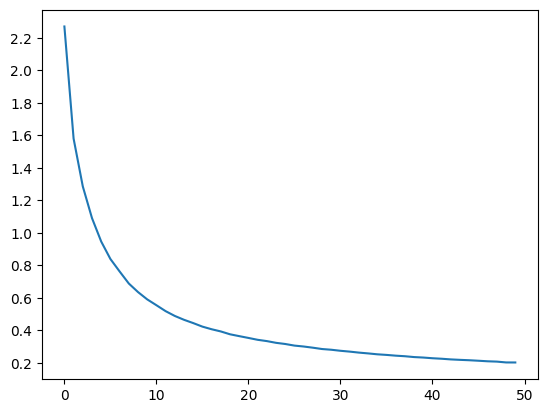

In [28]:
hidden_size = 128

print(f'English vocab size: {len(en_vocab)}')
print(f'Spanish vocab size: {len(es_vocab)}')

encoder = EncoderRNN(len(en_vocab), hidden_size).to(device)
# decoder = DecoderRNN(hidden_size, len(es_vocab)).to(device)
decoder = AttnDecoderRNN(hidden_size, len(es_vocab)).to(device)

train(train_loader, encoder, decoder, 50, print_every=1, plot_every=1)

In [1]:
import random

def evaluateRandomly(encoder, decoder, n=1):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], en_vocab, en_tokenizer)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [2]:
encoder.eval()
decoder.eval()


NameError: name 'encoder' is not defined

In [3]:
evaluateRandomly(encoder, decoder)

NameError: name 'encoder' is not defined